<a href="https://colab.research.google.com/github/pablex72/vi-phenology-analysis-/blob/main/SVM_only-of_final_seed_42_improve_ML_In_one_FINAL_LSTM_GRU_XGBoost_Random_Forest_SVM_mm44b_con_SCATTER_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random as rn
##################################################3
np.random.seed(42)

# Setting the seed for python random numbers
rn.seed(42)

# Setting the graph-level random seed.
tf.random.set_seed(42)
##########################################3

# Function to create features and targets
def create_features_and_targets(data, dates, feature_length):
    X = list()
    Y = list()
    datesF = list()
    for i in range(len(data) - feature_length - 1):
        # Excluir la columna 'Date' al crear las características
        X.append(data[i:(i + feature_length), 1:])  # Excluir la primera columna (Date)
        Y.append(data[i + feature_length, -1])
    X = np.array(X, dtype=np.float32)  # Convertir a float32
    Y = np.array(Y, dtype=np.float32)  # Convertir a float32
    datesF = np.array(dates[feature_length+1:])
    return datesF, X, Y



# Function to train and evaluate LSTM model
def train_evaluate_lstm(X_train, y_train, X_test):
    adam = tf.keras.optimizers.Adam(lr=0.001)

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=adam, loss="mean_squared_error")
    model.summary()

    history = model.fit(
    X_train.reshape(X_train.shape[0], X_train.shape[1], 1),  # Reshape to (samples, timesteps, features)
    y_train,
    epochs=100,
    batch_size=12,
    verbose=0,)


    y_pred_lstm = model.predict(X_test)

    r2_lstm = r2_score(y_test, y_pred_lstm)
    rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
    mse = mean_squared_error(y_test, y_pred_lstm, squared=True)
    mae = mean_absolute_error(y_test, y_pred_lstm)

    return y_pred_lstm, r2_lstm, rmse, mse, mae

# Function to train and evaluate SVM model
def train_evaluate_svm(X_train, y_train, X_test):
    regressor_svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    regressor_svm.fit(X_train, y_train)
    y_pred_svm = regressor_svm.predict(X_test)

    r2_svm = r2_score(y_test, y_pred_svm)
    rmse = mean_squared_error(y_test, y_pred_svm, squared=False)
    mse = mean_squared_error(y_test, y_pred_svm, squared=True)
    mae = mean_absolute_error(y_test, y_pred_svm)

    return y_pred_svm, r2_svm, rmse, mse, mae

# Function to train and evaluate Random Forest model
def train_evaluate_rf(X_train, y_train, X_test):
    regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_rf.fit(X_train, y_train)
    y_pred_rf = regressor_rf.predict(X_test)

    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
    mse_rf = mean_squared_error(y_test, y_pred_rf, squared=True)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)

    return y_pred_rf, r2_rf, rmse_rf, mse_rf, mae_rf

# Function to train and evaluate XGBoost model
def train_evaluate_xgb(X_train, y_train, X_test):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=True)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    return y_pred_xgb, r2_xgb, rmse_xgb, mse_xgb, mae_xgb

# Load and preprocess each CSV file
#files = ['/content/sg_smoothed_ndvi_farm1.csv', '/content/sg_smoothed_ndvi_farm2.csv', '/content/sg_smoothed_ndvi_farm3.csv', '/content/sg_smoothed_ndvi_farm4.csv']
files = ['/content/interpolated_data_farm1.csv', '/content/interpolated_data_farm2.csv', '/content/interpolated_data_farm3.csv', '/content/interpolated_data_farm4.csv']

results = []

for file in files:
    df = pd.read_csv(file)
    df_copy = df.copy()

    # Your preprocessing steps here...
    feature_length  = 1
    # Call the create_features_and_targets function
    dates, X, y = create_features_and_targets(df.values, df[['Date']].values.flatten(), feature_length)

    # Split the data into training and testing sets
    q_80 = int(len(dates) * 0.8)
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

    # Call the train_evaluate_lstm function
    y_pred_lstm, r2_lstm, rmse_lstm, mse_lstm, mae_lstm = train_evaluate_lstm(X_train, y_train, X_test)

###############################################################
    df['Target'] = df['NDVI'].shift(-1)
    target_df = df[:-1]

    # Creating Feature and Target
    X = target_df[['NDVI']].values
    y = target_df['Target'].values

    # Spliting the data into train(80%) and test(20%) parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
    # Splitting the dates
    train_dates = target_df.Date[:int(len(X)*0.80)]
    test_dates =  target_df.Date[int(len(X)*0.80):]

######################################
    # Call the train_evaluate_svm function
    y_pred_svm, r2_svm, rmse_svm, mse_svm, mae_svm = train_evaluate_svm(X_train, y_train, X_test)

    # Call the train_evaluate_rf function
    y_pred_rf, r2_rf, rmse_rf, mse_rf, mae_rf = train_evaluate_rf(X_train, y_train, X_test)

    # Call the train_evaluate_xgb function
    y_pred_xgb, r2_xgb, rmse_xgb, mse_xgb, mae_xgb = train_evaluate_xgb(X_train, y_train, X_test)

    # Append the results to the list
    results.append({
        "y_test":y_test,
        'file': file,
        'y_pred_lstm': y_pred_lstm,
        'r2_lstm': r2_lstm,
        'rmse_lstm': rmse_lstm,
        'mse_lstm': mse_lstm,
        'mae_lstm': mae_lstm,
        'y_pred_svm': y_pred_svm,
        'r2_svm': r2_svm,
        'rmse_svm': rmse_svm,
        'mse_svm': mse_svm,
        'mae_svm': mae_svm,
        'y_pred_rf': y_pred_rf,
        'r2_rf': r2_rf,
        'rmse_rf': rmse_rf,
        'mse_rf': mse_rf,
        'mae_rf': mae_rf,
        'y_pred_xgb': y_pred_xgb,
        'r2_xgb': r2_xgb,
        'rmse_xgb': rmse_xgb,
        'mse_xgb': mse_xgb,
        'mae_xgb': mae_xgb,
    })




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 16)             3136      
                                                                 
 dropout_1 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793 (

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_2 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             3136      
                                                                 
 dropout_3 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                6272      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_4 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             3136      
                                                                 
 dropout_5 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_6 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 16)             3136      
                                                                 
 dropout_7 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                6272      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793

In [ ]:
# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, result in enumerate(results):
    axs[i // 2, i % 2].scatter(result['y_test'], result['y_pred_svm'], label=f"SVM (R²={result['r2_svm']:.4f})", alpha=0.8, color='r')
    axs[i // 2, i % 2].scatter(result['y_test'], result['y_pred_rf'], label=f"Random Forest (R²={result['r2_rf']:.4f})", alpha=0.8, color='g')
    axs[i // 2, i % 2].scatter(result['y_test'], result['y_pred_xgb'], label=f"XGBoost (R²={result['r2_xgb']:.4f})", alpha=0.8, color='b')
    axs[i // 2, i % 2].scatter(result['y_test'], result['y_pred_lstm'], label=f"LSTM (R²={result['r2_lstm']:.4f})", alpha=0.8, color='c')
    axs[i // 2, i % 2].plot([min(result['y_test']), max(result['y_test'])], [min(result['y_test']), max(result['y_test'])], color='yellow', linestyle='--')
    axs[i // 2, i % 2].set_xlabel("Actual NDVI", fontsize=16)
    axs[i // 2, i % 2].set_ylabel("Predicted NDVI", fontsize=16)
    axs[i // 2, i % 2].tick_params(axis='x', labelsize=12)
    axs[i // 2, i % 2].tick_params(axis='y', labelsize=12)

    axs[i // 2, i % 2].set_title(f"Scatter Plot of Actual vs. Predicted NDVI Farm {i + 1}", fontsize=19)
    axs[i // 2, i % 2].legend(prop={"size": 14})
    axs[i // 2, i % 2].grid(True)

plt.tight_layout()
plt.show()


# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, result in enumerate(results):
    axs[i // 2, i % 2].plot(result['y_test'], linewidth=2, label='Original', color='y')
   # axs[i // 2, i % 2].scatter(range(len(result['y_pred_svm'])), result['y_pred_svm'], label='Predicted (SVM)', color='r', marker='o', alpha=0.8)
    axs[i // 2, i % 2].scatter(range(len(result['y_pred_rf'])), result['y_pred_rf'], label='Predicted (RF)', color='g', marker='o', alpha=0.8)
   # axs[i // 2, i % 2].scatter(range(len(result['y_pred_xgb'])), result['y_pred_xgb'], label='Predicted (XGBoost)', color='m', marker='o', alpha=0.8)
    #axs[i // 2, i % 2].scatter(range(len(result['y_pred_lstm'])), result['y_pred_lstm'], label='Predicted (LSTM)', color='c', marker='o', alpha=0.8)
    axs[i // 2, i % 2].set_xticks(range(0, len(test_dates.values), 5))
    axs[i // 2, i % 2].set_xticklabels(test_dates.values[::5], rotation=20,fontsize = 12)

   # axs[i // 2, i % 2].set_title(f"Time series prediction Farm {i + 1}", fontsize=19)
    axs[i // 2, i % 2].set_ylabel('NDVI',fontsize = 15)
    axs[i // 2, i % 2].tick_params(axis='y', labelsize=13.5)  # Add this line to set yticks fontsize

    axs[i // 2, i % 2].legend(loc='upper left', prop={"size": 14})
    axs[i // 2, i % 2].grid(True)



plt.tight_layout()
plt.show()

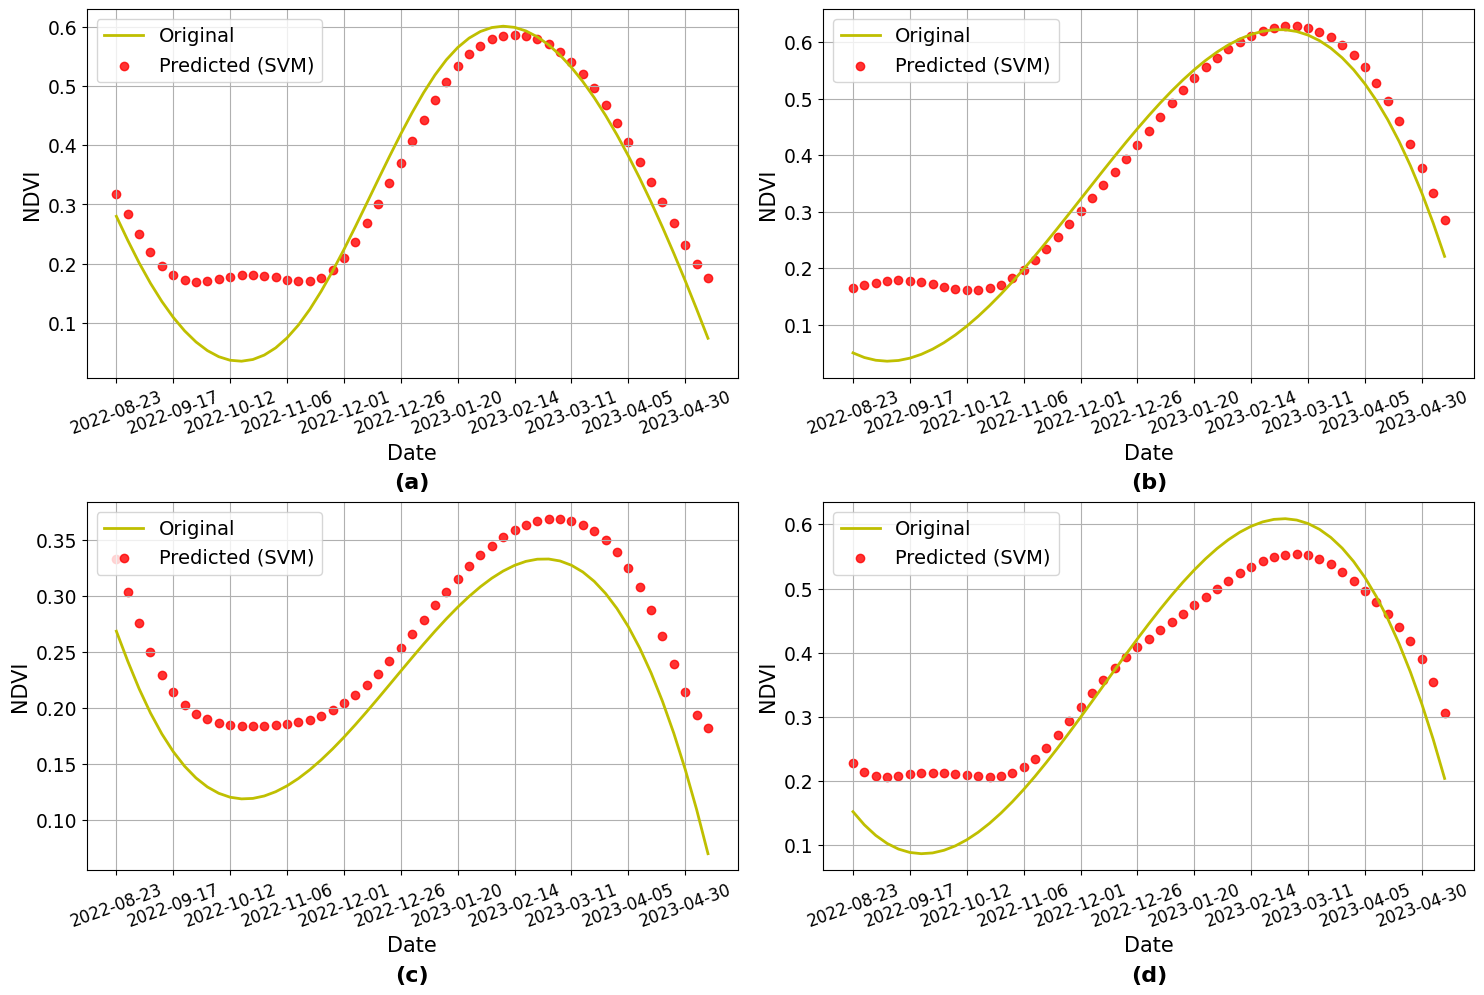

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, result in enumerate(results):
    axs[i // 2, i % 2].plot(result['y_test'], linewidth=2, label='Original', color='y')
    axs[i // 2, i % 2].scatter(range(len(result['y_pred_svm'])), result['y_pred_svm'], label='Predicted (SVM)', color='r', marker='o', alpha=0.8)

    #axs[i // 2, i % 2].scatter(range(len(result['y_pred_rf'])), result['y_pred_rf'], label='Predicted (RF)', color='g', marker='o', alpha=0.8)
    #axs[i // 2, i % 2].scatter(range(len(result['y_pred_xgb'])), result['y_pred_xgb'], label='Predicted (XGBoost)', color='m', marker='o', alpha=0.8)
    #axs[i // 2, i % 2].scatter(range(len(result['y_pred_lstm'])), result['y_pred_lstm'], label='Predicted (LSTM)', color='c', marker='o', alpha=0.8)

    axs[i // 2, i % 2].set_xticks(range(0, len(test_dates.values), 5))
    axs[i // 2, i % 2].set_xticklabels(test_dates.values[::5], rotation=20, fontsize=12)

    axs[i // 2, i % 2].set_ylabel('NDVI', fontsize=15)
    axs[i // 2, i % 2].set_xlabel("Date", fontsize=15)


    axs[i // 2, i % 2].tick_params(axis='y', labelsize=13.5)  # Add this line to set yticks fontsize

    axs[i // 2, i % 2].legend(loc='upper left', prop={"size": 14})
    axs[i // 2, i % 2].grid(True)

    # Centered letter below each plot
    axs[i // 2, i % 2].text(0.5, -0.30, f"({chr(ord('a') + i)})", transform=axs[i // 2, i % 2].transAxes, size=16, weight='bold', ha='center')

plt.tight_layout()
plt.show()


In [20]:
import csv

# Export SVM results to a CSV file
header = ["Farm", "Model", "RMSE", "R2", "MAE"]
rows = []

for i, result in enumerate(results):
    farm_number = i + 1
    model_name = "LSTM"
    row = [f"Farm {farm_number}", model_name, result[f"rmse_{model_name.lower()}"], result[f"r2_{model_name.lower()}"], result[f"mae_{model_name.lower()}"]]
    rows.append(row)

# Write to CSV file
csv_file_path = "svm_results.csv"
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(rows)


additional approach for  structure well csv

In [ ]:
import csv
import pandas as pd

# Your existing code for results...

# Group results by farm
results_by_farm = {}
for i, result in enumerate(results):
    farm_number = i + 1
    results_by_farm[f"Farm {farm_number}"] = result

# Create a DataFrame with the desired structure
data = []
for farm, result in results_by_farm.items():
    for model_name in ["SVM", "RF", "XGB", "LSTM"]:
        row = [farm, model_name, result[f"rmse_{model_name.lower()}"], result[f"r2_{model_name.lower()}"], result[f"mae_{model_name.lower()}"]]
        data.append(row)

# Create a DataFrame with the desired structure
df = pd.DataFrame(data, columns=["Farm", "Model", "RMSE", "R2", "MAE"])

# Pivot the DataFrame to reshape it with the desired structure
df_pivoted = df.pivot(index="Model", columns="Farm")

# Flatten the multi-level columns
df_pivoted.columns = [f"{col[1]}_{col[0]}" for col in df_pivoted.columns]

# Reset the index to make "Model" a regular column
df_pivoted.reset_index(inplace=True)

# Write to CSV file
csv_file_path = "results35353535.csv"
df_pivoted.to_csv(csv_file_path, index=False)


#to measure the executino time

In [ ]:
# import csv
# import time
# import matplotlib.pyplot as plt

# # Assuming 'results' is a list of dictionaries containing your results

# # Your existing code for data preparation

# # Function to train and predict for a specific model
# def train_and_predict(model, X_train, y_train, X_test):
#     start_time = time.time()
#     # Your code for training the model
#     model.fit(X_train, y_train)
#     # Your code for making predictions
#     y_pred = model.predict(X_test)
#     end_time = time.time()
#     execution_time = end_time - start_time
#     return y_pred, execution_time

# # Export results to a CSV file
# header = ["Farm", "Model", "RMSE", "R2", "MAE", "Execution Time"]
# rows = []

# for i, result in enumerate(results):
#     farm_number = i + 1
#     for model_name, model_instance in [("SVM", regressor_svm), ("RF", regressor_rf), ("XGB", xgb_model), ("LSTM", model)]:
#         X_train, y_train, X_test, y_test = prepare_data_for_farm(farm_number)

#         # Check if the keys are present in the result dictionary
#         if f"rmse_{model_name.lower()}" in result:
#             y_pred, execution_time = train_and_predict(model_instance, X_train, y_train, X_test)

#             # Your code for evaluating model performance and storing results

#             row = [f"Farm {farm_number}", model_name, result.get(f"rmse_{model_name.lower()}", None), result.get(f"r2_{model_name.lower()}", None), result.get(f"mae_{model_name.lower()}", None), execution_time]
#             rows.append(row)

# # Write to CSV file
# csv_file_path = "results_with_time.csv"
# with open(csv_file_path, 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(header)
#     writer.writerows(rows)

# # Your existing code for plotting results

# plt.tight_layout()
# plt.show()
